In [54]:
# train autoencoder for classification with no compression in the bottleneck layer

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing  import image
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import h5py
from tensorflow.keras import backend as K

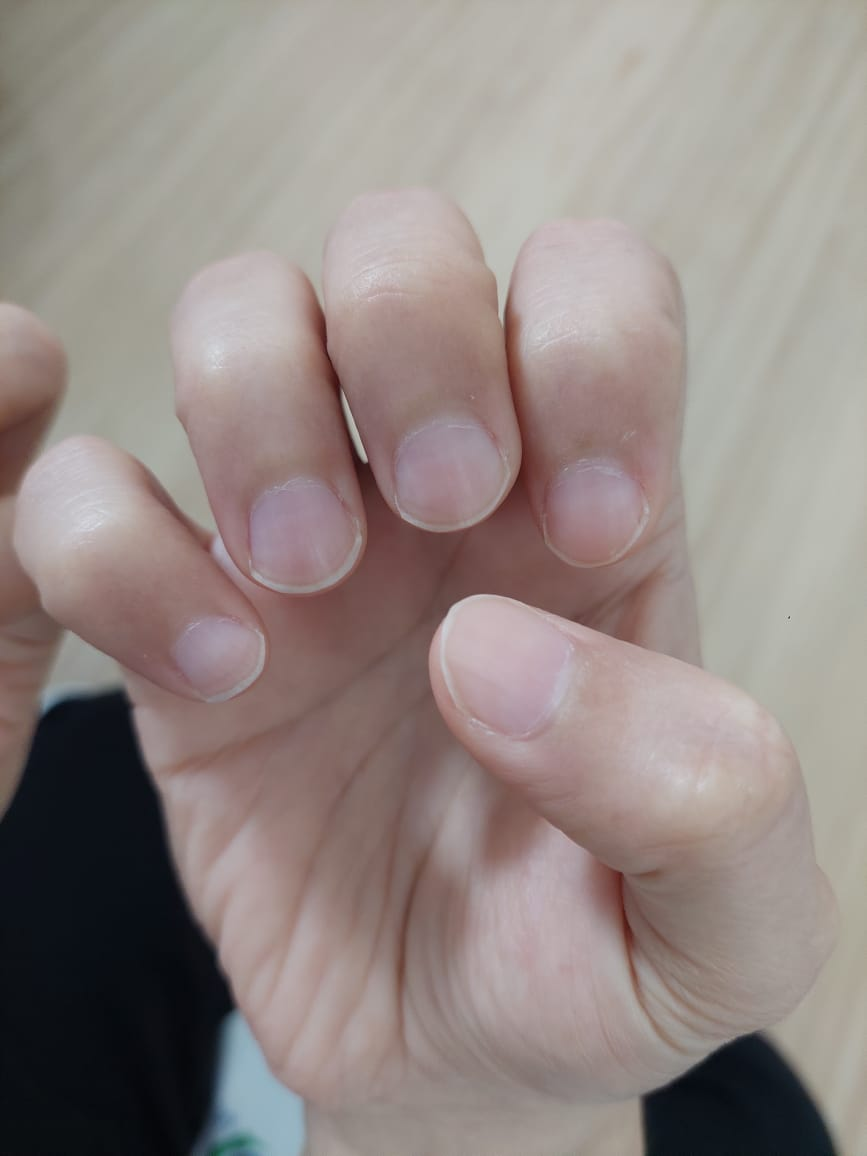

In [55]:
#Importante imagens através de listas

listas = glob.glob('IMAGENS ANEMIA (Padronizado)/*')
Image.open(listas[1])

In [56]:
#Definindo o target de todas imagens

def myTarget(imagem):
    imgm = float(imagem.split('/')[-1].split('__')[1].split('_')[1])
    return imgm

target_list = []
for img_path in listas:

    if myTarget(img_path) >= 12:
        target_list.append(1)

    else:
        target_list.append(0)

target_list_array = np.array(target_list)

target_list_array

array([0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0])

In [57]:
#Pre processamentos necessários nas imagens (ver melhor oque acontece aqui)

train_images = []

for img in listas:
    i = image.load_img(img, target_size=(224,224))
    i = image.img_to_array(i)
    train_images.append(i)

train_images = np.array(train_images)

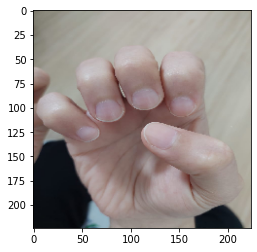

In [58]:
plt.imshow(train_images[1]/255)

In [59]:
#Shape base de dados e target

print(target_list_array.shape, train_images.shape)

(31,) (31, 224, 224, 3)


In [60]:
#Função de normalização
# (X - X.min())/(X.max() - X.min())

In [61]:
#Alterando dimensionalidade da base de dados para entrar no autoencoder

train_data = train_images.reshape(train_images.shape[0],150528)

In [62]:
#Normalizando os dados 

train_data = train_data/train_data.max()

(24, 150528)
(7, 150528)
200
150528


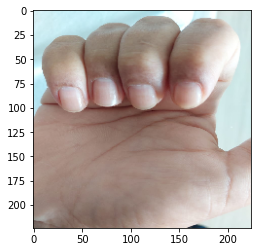

In [63]:
#Dividindo entre treino e teste

X_train, X_test, y_train, y_test = train_test_split(train_data, target_list_array, test_size=0.20, random_state=0)

print(X_train.shape)
print(X_test.shape)

n_inputs = 200
n_inputstrue = X_train.shape[1]
print(n_inputs)
print(n_inputstrue)

#Voltando para 4 dimensões e plotando

X_train4d = X_train.reshape(24,224,224,3)
X_test4d = X_test.reshape(7,224,224,3)

plt.imshow(X_train4d[2])

In [64]:
#Dicionário com a base de dados de teste verdadeira

test_data_true = {}

for i in range(len(X_test)):
    test_data_true[i] = X_test


In [65]:
tf.keras.backend.clear_session()

In [40]:
#Encoder
# define encoder

visible = Input(shape=(n_inputstrue,))

# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

# bottleneck (Gargalo)
n_bottleneck = n_inputs
bottleneck = Dense(n_bottleneck)(e)


2023-03-17 10:38:19.420845: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 240844800 exceeds 10% of free system memory.
2023-03-17 10:38:19.556603: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 240844800 exceeds 10% of free system memory.


In [41]:
#Decoder
# define decoder

#level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

# output layer
output = Dense(n_inputstrue, activation='linear')(d)

# define autoencoder model
model = Model(inputs=visible, outputs=output)

In [42]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150528)]          0         
_________________________________________________________________
dense (Dense)                (None, 400)               60211600  
_________________________________________________________________
batch_normalization (BatchNo (None, 400)               1600      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               80200     
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               800       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 200)               0     

In [43]:
#Compile autoencoder model
#Adicionando informações relevantes para treinar a rede, como o otimizador e a função custo
#Treinar é encontrar o melhor conjunto de pesos para mapear entradas para saídas. Como você faz isso o .compile nos fornece

model.compile(optimizer='adam',loss='mse')

In [44]:
#Treino

history = model.fit(X_train, X_train, epochs=2, batch_size=31, verbose=0, validation_data=(X_test,X_test))

2023-03-17 10:38:51.287418: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-03-17 10:38:51.328660: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2495995000 Hz


In [45]:
#Importando Rede Neural Treinada no terminal 

# history = tf.keras.models.load_model('saved_models/train_anemina_2epochs')



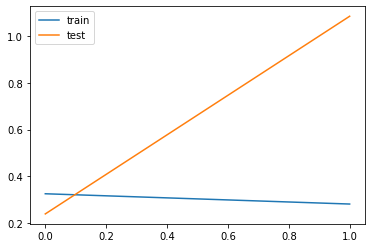

In [46]:
# plot loss

# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
# pyplot.legend()
# pyplot.show()

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [47]:
#Imagem reconstruidas (novas)

img_reconstructed = model.predict(X_test)

In [48]:
#Dicionário com a base de dados de teste fake

test_data_fake = {}

for i in range(len(img_reconstructed)):
    test_data_fake[i] = img_reconstructed

In [49]:
print(len(img_reconstructed))
print(img_reconstructed[1].shape)

7
(150528,)


In [50]:
#Voltando as images criadas de array(11,150528) para array(11,224,224,3)

img_reconstructed = img_reconstructed.reshape(7,224,224,3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)
5.3325715
-1.9739941


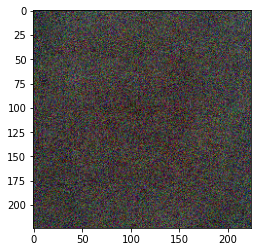

In [51]:
#Plotando as imagens fake

print(img_reconstructed[1].shape)
print(img_reconstructed.max())
print(img_reconstructed.min())

plt.imshow(img_reconstructed[2]/7)

plt.show()

In [ ]:
#Plotando várias imagens fake

# fig = plt.figure(figsize=(8, 8))

# for i in range(1, 7*1 +1):
#     img = np.random.randint(10, size=(h,w))
#     fig.add_subplot(rows, columns, i)
#     plt.imshow(img)
# plt.show()